In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from datetime import datetime

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

In [3]:
# Study window
START = "2017-01-01"
END   = "2025-08-01"

# Risk-free (annual) — India 10Y G-Sec ~ 7%
RF_ANNUAL = 0.07
RF_DAILY  = RF_ANNUAL / 252

# If True: keep only the common period where ALL chosen assets have data
# If False: compute each asset on its own available history
USE_COMMON_SAMPLE = True


In [4]:
# InvITs
invits = [
    "IRBINVIT.NS",   # IRB InvIT
    "INDIGRID.NS",   # India Grid Trust
    "PGINVIT.NS"     # PowerGrid InvIT
]

# REITs (tickers can vary on Yahoo; these are common — auto-drop if unavailable)
reits = [
    "EMBASSY.NS",     # Embassy Office Parks REIT
    "MINDSPACE.NS",   # Mindspace Business Parks REIT
    "BIRET.NS"        # Nexus Select Trust (sometimes NEXUSREIT.NS)
]

# Infra stocks
stocks = [
    "IRB.NS",
    "LT.NS",
    "ADANIPORTS.NS",
    "NTPC.NS",
    "POWERGRID.NS"
]

# Market proxies (priority order; code will pick the first available)
market_priority = [
    "INFRABEES.NS",   # Nippon India ETF Infra BeES (investable)
    "^CNXINFRA",      # Nifty Infrastructure Index
    "^NSEI"           # Nifty 50
]

all_tickers = invits + reits + stocks + market_priority

# Label types
instrument_type = {**{t:"InvIT" for t in invits},
                   **{t:"REIT"  for t in reits},
                   **{t:"Stock" for t in stocks}}


In [5]:
instrument_meta = {
    "IRBINVIT.NS":  {"Name":"IRB InvIT Fund", "Sector":"Roads / Highways",
                     "Sponsor":"IRB Infrastructure Developers", "Listing_Date":"2017-05"},
    "INDIGRID.NS":  {"Name":"IndiGrid (India Grid Trust)", "Sector":"Power Transmission",
                     "Sponsor":"Sterlite Power (orig.) / KKR (IM owner)", "Listing_Date":"2017-06-06"},
    "PGINVIT.NS":   {"Name":"POWERGRID InvIT", "Sector":"Power Transmission",
                     "Sponsor":"Power Grid Corporation of India", "Listing_Date":"2021-05-14"},

    "EMBASSY.NS":   {"Name":"Embassy Office Parks REIT", "Sector":"Commercial Offices (REIT)",
                     "Sponsor":"Embassy / Blackstone (orig.)", "Listing_Date":"2019-03"},
    "MINDSPACE.NS": {"Name":"Mindspace Business Parks REIT", "Sector":"Commercial Offices (REIT)",
                     "Sponsor":"K Raheja Corp", "Listing_Date":"2020-08"},
    "BIRET.NS": {
        "Name": "Brookfield India Real Estate Trust",
        "Sector": "Commercial Offices (REIT)",
        "Sponsor": "Brookfield Asset Management",
        "Listing_Date": "2021-02"},

    "IRB.NS":       {"Name":"IRB Infrastructure Developers", "Sector":"Roads / BOT / EPC",
                     "Sponsor":"—", "Listing_Date":"2008-02-25"},
    "LT.NS":        {"Name":"Larsen & Toubro", "Sector":"Engineering & Construction (EPC)",
                     "Sponsor":"—", "Listing_Date":"2004-06-23"},
    "ADANIPORTS.NS":{"Name":"Adani Ports & SEZ", "Sector":"Ports / Logistics",
                     "Sponsor":"—", "Listing_Date":"2007-11"},
    "NTPC.NS":      {"Name":"NTPC Limited", "Sector":"Power Generation (PSU)",
                     "Sponsor":"—", "Listing_Date":"2004-11-05"},
    "POWERGRID.NS": {"Name":"Power Grid Corporation", "Sector":"Power Transmission (PSU)",
                     "Sponsor":"—", "Listing_Date":"2007-10"},

    "INFRABEES.NS": {"Name":"Nippon India ETF Infra BeES", "Sector":"ETF (Infra basket)",
                     "Sponsor":"—", "Listing_Date":None},
    "^CNXINFRA":    {"Name":"Nifty Infrastructure Index", "Sector":"Index",
                     "Sponsor":"—", "Listing_Date":None},
    "^NSEI":        {"Name":"Nifty 50 Index", "Sector":"Index",
                     "Sponsor":"—", "Listing_Date":None}
}


In [6]:
def download_prices(tickers, start, end):
    df = yf.download(tickers, start=start, end=end, group_by="column", auto_adjust=False, progress=False)
    # Choose Adj Close if present; else Close
    top = df.columns.get_level_values(0).unique().tolist()
    field = "Adj Close" if "Adj Close" in top else "Close"
    prices_ = df[field].copy()
    if isinstance(prices_, pd.Series):
        prices_ = prices_.to_frame()
    # Drop tickers with all NaN
    drop_all_nan = [c for c in prices_.columns if prices_[c].dropna().empty]
    if drop_all_nan:
        print("Dropping tickers with no data:", drop_all_nan)
        prices_ = prices_.drop(columns=drop_all_nan)
    return prices_

prices = download_prices(all_tickers, START, END)
print("Fetched columns:", list(prices.columns))


Fetched columns: ['ADANIPORTS.NS', 'BIRET.NS', 'EMBASSY.NS', 'INDIGRID.NS', 'INFRABEES.NS', 'IRB.NS', 'IRBINVIT.NS', 'LT.NS', 'MINDSPACE.NS', 'NTPC.NS', 'PGINVIT.NS', 'POWERGRID.NS', '^CNXINFRA', '^NSEI']


In [7]:
def download_prices(tickers, start, end):
    df = yf.download(tickers, start=start, end=end, group_by="column", auto_adjust=False, progress=False)
    # Choose Adj Close if present; else Close
    top = df.columns.get_level_values(0).unique().tolist()
    field = "Adj Close" if "Adj Close" in top else "Close"
    prices_ = df[field].copy()
    if isinstance(prices_, pd.Series):
        prices_ = prices_.to_frame()
    # Drop tickers with all NaN
    drop_all_nan = [c for c in prices_.columns if prices_[c].dropna().empty]
    if drop_all_nan:
        print("Dropping tickers with no data:", drop_all_nan)
        prices_ = prices_.drop(columns=drop_all_nan)
    return prices_

prices = download_prices(all_tickers, START, END)
print("Fetched columns:", list(prices.columns))


Fetched columns: ['ADANIPORTS.NS', 'BIRET.NS', 'EMBASSY.NS', 'INDIGRID.NS', 'INFRABEES.NS', 'IRB.NS', 'IRBINVIT.NS', 'LT.NS', 'MINDSPACE.NS', 'NTPC.NS', 'PGINVIT.NS', 'POWERGRID.NS', '^CNXINFRA', '^NSEI']


In [8]:
available_markets = [m for m in market_priority if m in prices.columns]
if not available_markets:
    raise ValueError("No market proxy found. Try changing 'market_priority'.")
MARKET = available_markets[0]
print("Using market proxy:", MARKET)


Using market proxy: INFRABEES.NS


In [9]:
returns_raw = prices.pct_change()

if USE_COMMON_SAMPLE:
    # keep the chosen market + all analysis tickers that remain
    analysis_cols = [c for c in prices.columns if (c == MARKET) or (not c.startswith("^"))]
    returns = returns_raw[analysis_cols].dropna(how="any")
else:
    returns = returns_raw.copy()

print("Returns window:", returns.index.min(), "→", returns.index.max())
returns.head()


Returns window: 2021-05-17 00:00:00 → 2025-07-31 00:00:00


C:\Users\HP\AppData\Local\Temp\ipykernel_19220\4007823473.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_raw = prices.pct_change()


Ticker,ADANIPORTS.NS,BIRET.NS,EMBASSY.NS,INDIGRID.NS,INFRABEES.NS,IRB.NS,IRBINVIT.NS,LT.NS,MINDSPACE.NS,NTPC.NS,PGINVIT.NS,POWERGRID.NS
Date,,,,,,,,,,,,
2021-05-17,0.0282,-0.0142,0.0091,-0.0027,0.0047,-0.0019,0.0000,-0.0203,-0.0038,0.0013,0.0155,-0.0020
2021-05-18,0.0288,-0.0098,0.0206,0.0081,0.0127,0.0108,0.0000,0.0220,0.0050,0.0049,0.0262,0.0206
2021-05-19,-0.0045,0.0267,0.0035,0.0077,-0.0023,0.0275,0.0259,-0.0098,-0.0014,-0.0013,0.0283,0.0028
2021-05-20,-0.0087,-0.0095,0.0008,0.0025,-0.0034,-0.0118,0.0000,0.0045,0.0172,-0.0018,0.0149,-0.0205
2021-05-21,0.0046,-0.0085,-0.0112,0.0102,0.0059,0.0023,0.0000,0.0059,-0.0060,0.0098,-0.0094,-0.0044


In [10]:
daily_mean = returns.mean()
daily_vol  = returns.std()

annual_ret = daily_mean * 252
annual_vol = daily_vol  * np.sqrt(252)
sharpe     = (annual_ret - RF_ANNUAL) / annual_vol

summary = pd.DataFrame({
    "Annual_Return": annual_ret,
    "Annual_Volatility": annual_vol,
    "Sharpe_Ratio": sharpe
})

# Add Type & Meta
summary["Type"]         = summary.index.map(lambda x: instrument_type.get(x, "Index/ETF"))
summary["Name"]         = summary.index.map(lambda x: instrument_meta.get(x, {}).get("Name"))
summary["Sector"]       = summary.index.map(lambda x: instrument_meta.get(x, {}).get("Sector"))
summary["Listing_Date"] = summary.index.map(lambda x: instrument_meta.get(x, {}).get("Listing_Date"))
summary["Sponsor"]      = summary.index.map(lambda x: instrument_meta.get(x, {}).get("Sponsor"))

# Reorder for readability
summary = summary[["Name","Type","Sector","Listing_Date","Sponsor","Annual_Return","Annual_Volatility","Sharpe_Ratio"]]
summary.sort_values(["Type","Name"], inplace=True)

# Display a pretty version
disp = summary.copy()
disp["Annual_Return"]     = (disp["Annual_Return"]*100).round(2)
disp["Annual_Volatility"] = (disp["Annual_Volatility"]*100).round(2)
disp["Sharpe_Ratio"]      = disp["Sharpe_Ratio"].round(2)
disp


,Name,Type,Sector,Listing_Date,Sponsor,Annual_Return,Annual_Volatility,Sharpe_Ratio
Ticker,,,,,,,,
INFRABEES.NS,Nippon India ETF Infra BeES,Index/ETF,ETF (Infra basket),None,—,20.2600,16.3800,0.8100
IRBINVIT.NS,IRB InvIT Fund,InvIT,Roads / Highways,2017-05,IRB Infrastructure Developers,5.6300,25.7400,-0.0500
INDIGRID.NS,IndiGrid (India Grid Trust),InvIT,Power Transmission,2017-06-06,Sterlite Power (orig.) / KKR (IM owner),16.1400,10.9800,0.8300
PGINVIT.NS,POWERGRID InvIT,InvIT,Power Transmission,2021-05-14,Power Grid Corporation of India,8.8500,11.9900,0.1500
BIRET.NS,Brookfield India Real Estate Trust,REIT,Commercial Offices (REIT),2021-02,Brookfield Asset Management,13.4200,16.9700,0.3800
EMBASSY.NS,Embassy Office Parks REIT,REIT,Commercial Offices (REIT),2019-03,Embassy / Blackstone (orig.),13.0000,18.8500,0.3200
MINDSPACE.NS,Mindspace Business Parks REIT,REIT,Commercial Offices (REIT),2020-08,K Raheja Corp,15.9400,16.5300,0.5400
ADANIPORTS.NS,Adani Ports & SEZ,Stock,Ports / Logistics,2007-11,—,23.5500,38.8200,0.4300
IRB.NS,IRB Infrastructure Developers,Stock,Roads / BOT / EPC,2008-02-25,—,47.3800,49.4600,0.8200


In [11]:
def _get_from_dictlike(obj, keys):
    for k in keys:
        if isinstance(obj, dict):
            if k in obj and obj[k] is not None:
                return obj[k]
        else:
            val = getattr(obj, k, None)
            if val is not None:
                return val
    return None

def fetch_market_caps(tickers, prices_df=None):
    out = {}
    for t in tickers:
        try:
            if t.startswith("^"):  # indices
                out[t] = np.nan
                continue
            tk = yf.Ticker(t)

            # fast_info
            fi = getattr(tk, "fast_info", {}) or {}
            mc  = _get_from_dictlike(fi, ["market_cap","marketCap"])
            shs = _get_from_dictlike(fi, ["shares_outstanding","sharesOutstanding","shares"])
            lp  = _get_from_dictlike(fi, ["last_price","lastPrice"])

            # fallback .info
            if mc is None:
                try:
                    info = tk.info
                except Exception:
                    info = {}
                if mc is None:
                    mc = _get_from_dictlike(info, ["marketCap","market_cap"])
                if shs is None:
                    shs = _get_from_dictlike(info, ["sharesOutstanding","shares_outstanding"])
                if lp is None:
                    lp = _get_from_dictlike(info, ["regularMarketPrice","previousClose","currentPrice"])

            # compute last price × shares if needed
            if (mc is None) and (shs is not None):
                if lp is None and (prices_df is not None) and (t in prices_df.columns):
                    s = prices_df[t].dropna()
                    lp = s.iloc[-1] if not s.empty else None
                if lp is not None:
                    mc = float(shs) * float(lp)

            out[t] = mc if mc is not None else np.nan
        except Exception:
            out[t] = np.nan
    return pd.Series(out, name="Market_Cap_INR")

mcap = fetch_market_caps(summary.index.tolist(), prices_df=prices)
summary["Market_Cap_INR"] = mcap
summary["Market_Cap_Crore_INR"] = summary["Market_Cap_INR"] / 1e7

# Pretty display with mcap
disp = summary.copy()
disp["Annual_Return"]     = (disp["Annual_Return"]*100).round(2)
disp["Annual_Volatility"] = (disp["Annual_Volatility"]*100).round(2)
disp["Sharpe_Ratio"]      = disp["Sharpe_Ratio"].round(2)
disp["Market_Cap_Crore_INR"] = disp["Market_Cap_Crore_INR"].round(1)

disp = disp[["Name","Type","Sector","Listing_Date","Sponsor",
             "Market_Cap_Crore_INR","Annual_Return","Annual_Volatility","Sharpe_Ratio"]]
disp.sort_values(["Type","Name"])


,Name,Type,Sector,Listing_Date,Sponsor,Market_Cap_Crore_INR,Annual_Return,Annual_Volatility,Sharpe_Ratio
Ticker,,,,,,,,,
INFRABEES.NS,Nippon India ETF Infra BeES,Index/ETF,ETF (Infra basket),None,—,NaN,20.2600,16.3800,0.8100
IRBINVIT.NS,IRB InvIT Fund,InvIT,Roads / Highways,2017-05,IRB Infrastructure Developers,"7,803.7000",5.6300,25.7400,-0.0500
INDIGRID.NS,IndiGrid (India Grid Trust),InvIT,Power Transmission,2017-06-06,Sterlite Power (orig.) / KKR (IM owner),"14,049.7000",16.1400,10.9800,0.8300
PGINVIT.NS,POWERGRID InvIT,InvIT,Power Transmission,2021-05-14,Power Grid Corporation of India,"8,692.3000",8.8500,11.9900,0.1500
BIRET.NS,Brookfield India Real Estate Trust,REIT,Commercial Offices (REIT),2021-02,Brookfield Asset Management,"20,948.3000",13.4200,16.9700,0.3800
EMBASSY.NS,Embassy Office Parks REIT,REIT,Commercial Offices (REIT),2019-03,Embassy / Blackstone (orig.),"41,007.2000",13.0000,18.8500,0.3200
MINDSPACE.NS,Mindspace Business Parks REIT,REIT,Commercial Offices (REIT),2020-08,K Raheja Corp,"28,442.8000",15.9400,16.5300,0.5400
ADANIPORTS.NS,Adani Ports & SEZ,Stock,Ports / Logistics,2007-11,—,"319,680.1000",23.5500,38.8200,0.4300
IRB.NS,IRB Infrastructure Developers,Stock,Roads / BOT / EPC,2008-02-25,—,"26,378.7000",47.3800,49.4600,0.8200


In [12]:
def fit_capm_table(returns_df, market_col, rf_daily_value=RF_DAILY):
    out = []
    cols = [c for c in returns_df.columns if c != market_col]
    rf = pd.Series(rf_daily_value, index=returns_df.index)
    for t in cols:
        df = returns_df[[t, market_col]].dropna()
        if df.empty:
            continue
        ex_i = df[t] - rf.reindex(df.index)
        ex_m = df[market_col] - rf.reindex(df.index)

        X = sm.add_constant(ex_m.values)
        y = ex_i.values
        model = sm.OLS(y, X, missing="drop").fit()

        alpha_daily = model.params[0]
        beta        = model.params[1]
        alpha_ann   = alpha_daily * 252

        out.append({
            "Ticker": t,
            "Alpha_annual": alpha_ann,
            "Beta": beta,
            "t_alpha": model.tvalues[0],
            "t_beta":  model.tvalues[1],
            "R2": float(model.rsquared),
            "N_obs": int(model.nobs)
        })
    return pd.DataFrame(out).set_index("Ticker").sort_values("Alpha_annual", ascending=False)

capm = fit_capm_table(returns, MARKET, RF_DAILY)

# Merge meta for readability and format
capm_disp = capm.join(summary[["Name","Type","Sector"]], how="left")
capm_disp = capm_disp[["Name","Type","Sector","Alpha_annual","Beta","t_alpha","t_beta","R2","N_obs"]]

capm_disp["Alpha_annual"] = (capm_disp["Alpha_annual"]*100).round(2)
capm_disp["Beta"]         = capm_disp["Beta"].round(2)
capm_disp["t_alpha"]      = capm_disp["t_alpha"].round(2)
capm_disp["t_beta"]       = capm_disp["t_beta"].round(2)
capm_disp["R2"]           = capm_disp["R2"].round(2)

print(f"Market proxy used for CAPM: {MARKET}")
capm_disp.sort_values(["Type","Name"])


Market proxy used for CAPM: INFRABEES.NS


,Name,Type,Sector,Alpha_annual,Beta,t_alpha,t_beta,R2,N_obs
Ticker,,,,,,,,,
IRBINVIT.NS,IRB InvIT Fund,InvIT,Roads / Highways,-3.6800,0.1700,-0.2900,3.6000,0.0100,1044
INDIGRID.NS,IndiGrid (India Grid Trust),InvIT,Power Transmission,7.7700,0.1000,1.4500,5.0600,0.0200,1044
PGINVIT.NS,POWERGRID InvIT,InvIT,Power Transmission,0.7300,0.0800,0.1200,3.7400,0.0100,1044
BIRET.NS,Brookfield India Real Estate Trust,REIT,Commercial Offices (REIT),4.6000,0.1400,0.5600,4.2900,0.0200,1044
EMBASSY.NS,Embassy Office Parks REIT,REIT,Commercial Offices (REIT),4.9200,0.0800,0.5300,2.2800,0.0000,1044
MINDSPACE.NS,Mindspace Business Parks REIT,REIT,Commercial Offices (REIT),7.7200,0.0900,0.9500,2.9700,0.0100,1044
ADANIPORTS.NS,Adani Ports & SEZ,Stock,Ports / Logistics,0.2000,1.2300,0.0100,19.6600,0.2700,1044
IRB.NS,IRB Infrastructure Developers,Stock,Roads / BOT / EPC,23.9800,1.2400,1.0800,14.4900,0.1700,1044
LT.NS,Larsen & Toubro,Stock,Engineering & Construction (EPC),8.3000,0.8800,0.8700,23.9600,0.3600,1044


In [13]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

prices.to_csv(f"india_infra_prices_{timestamp}.csv")
returns.to_csv(f"india_infra_returns_{timestamp}.csv")
disp.to_csv(f"india_infra_summary_{timestamp}.csv", index_label="Ticker")
capm_disp.to_csv(f"india_infra_capm_{timestamp}.csv", index_label="Ticker")

print("Saved CSVs with timestamp:", timestamp)


Saved CSVs with timestamp: 20251123_2324


In [14]:
def _normalize_dt_index(idx: pd.Index) -> pd.DatetimeIndex:
    # Make any index tz-naive and normalized to date (00:00)
    idx = pd.to_datetime(idx, utc=True, errors="coerce")
    idx = idx.tz_convert(None).normalize()
    return idx

def total_return_series_from_price_and_dividends(px: pd.Series, div: pd.Series | None) -> pd.Series:
    px = px.dropna().copy()
    px.index = _normalize_dt_index(px.index)

    # price return
    r_price = px.pct_change().fillna(0.0)

    # dividend return only on ex-dates: cash / previous close
    r_div = pd.Series(0.0, index=px.index)
    if div is not None and not div.empty:
        div = div.copy()
        div.index = _normalize_dt_index(div.index)
        # if multiple payouts on same date, sum them
        div = div.groupby(div.index).sum()
        # align to price index; zero elsewhere
        aligned_cash = div.reindex(px.index).fillna(0.0)
        r_div = (aligned_cash / px.shift(1)).fillna(0.0)

    tr = (1.0 + r_price + r_div).cumprod()
    return tr

# Build TR panel for InvITs + REITs; others stay price-only
tr_prices = prices.copy()
tickers_tr = [t for t in (set(invits + reits)) if t in prices.columns]

for t in tickers_tr:
    try:
        div = yf.Ticker(t).dividends
    except Exception:
        div = pd.Series(dtype=float)
    tr_prices[t] = total_return_series_from_price_and_dividends(prices[t], div)

# Total-return returns
tr_returns = tr_prices.pct_change().dropna(how="any")
print("Total-return series built for:", sorted(tickers_tr))

Total-return series built for: ['BIRET.NS', 'EMBASSY.NS', 'INDIGRID.NS', 'IRBINVIT.NS', 'MINDSPACE.NS', 'PGINVIT.NS']


C:\Users\HP\AppData\Local\Temp\ipykernel_19220\3688043232.py:40: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  tr_returns = tr_prices.pct_change().dropna(how="any")


In [15]:
# Expect a CSV with columns: Date, Yield_Annual  (either 0.07 or 7.0 for 7%)
# If not present, we'll fall back to RF_DAILY constant.
import os

def build_rf_daily(index_like: pd.DatetimeIndex, csv_path: str = "rbi_10y_gsec.csv") -> pd.Series:
    if not os.path.exists(csv_path):
        print("RBI RF file not found → using constant RF_DAILY.")
        return pd.Series(RF_DAILY, index=index_like)

    gsec = pd.read_csv(csv_path, parse_dates=["Date"])
    gsec = gsec.set_index("Date").sort_index()
    col = "Yield_Annual"
    if col not in gsec.columns:
        raise ValueError("CSV must contain a 'Yield_Annual' column.")
    y = gsec[col].astype(float)
    # If provided in percent (e.g., 7.2), convert to decimal
    y = y.where(y <= 1.0, y / 100.0)
    rf_daily = (y / 252.0).reindex(index_like, method="ffill")
    return rf_daily

# Build RF series aligned to BOTH price-return panels
rf_daily_returns = build_rf_daily(returns.index)
rf_daily_tr_returns = build_rf_daily(tr_returns.index)


RBI RF file not found → using constant RF_DAILY.
RBI RF file not found → using constant RF_DAILY.


In [16]:
def capm_hac(excess_asset: pd.Series, excess_mkt: pd.Series, hac_lags: int = 5):
    X = sm.add_constant(excess_mkt.values)
    y = excess_asset.values
    model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
    alpha_d, beta = model.params
    return {
        "Alpha_annual": alpha_d * 252.0,
        "Beta": beta,
        "t_alpha": model.tvalues[0],
        "t_beta":  model.tvalues[1],
        "R2": float(model.rsquared),
        "N_obs": int(model.nobs),
    }

def run_capm_panel(ret_df: pd.DataFrame, market_col: str, rf_daily: pd.Series, hac_lags: int = 5):
    out = []
    cols = [c for c in ret_df.columns if c != market_col and c in rf_daily.index.names or True]
    df = ret_df[[market_col]].dropna()
    for t in ret_df.columns:
        if t == market_col:
            continue
        tmp = ret_df[[t, market_col]].dropna()
        if tmp.empty:
            continue
        rf = rf_daily.reindex(tmp.index)
        ex_i = tmp[t] - rf
        ex_m = tmp[market_col] - rf
        res = capm_hac(ex_i, ex_m, hac_lags=hac_lags)
        res.update({"Ticker": t})
        out.append(res)
    res_df = pd.DataFrame(out).set_index("Ticker")
    return res_df

def capm_with_robustness(ret_df, rf_daily, market_list):
    results = {}
    for m in market_list:
        if m not in ret_df.columns:
            continue
        res = run_capm_panel(ret_df, m, rf_daily, hac_lags=5)
        res = res.join(summary[["Name","Type","Sector"]], how="left")
        results[m] = res
    return results

# A) Price-only returns, constant RF & time-varying RF
robust_price_constRF = capm_with_robustness(returns, rf_daily_returns*0 + RF_DAILY, market_priority)
robust_price_timeRF  = capm_with_robustness(returns, rf_daily_returns,               market_priority)

# B) Total-return panel for InvITs/REITs, constant RF & time-varying RF
robust_TR_constRF = capm_with_robustness(tr_returns, rf_daily_tr_returns*0 + RF_DAILY, market_priority)
robust_TR_timeRF  = capm_with_robustness(tr_returns, rf_daily_tr_returns,              market_priority)

# Quick peek (choose the market you saw used earlier, e.g., MARKET)
def fmt_capm_table(df):
    d = df.copy()
    d["Alpha_annual"] = (d["Alpha_annual"]*100).round(2)
    d["Beta"] = d["Beta"].round(2)
    d["t_alpha"] = d["t_alpha"].round(2)
    d["t_beta"] = d["t_beta"].round(2)
    d["R2"] = d["R2"].round(2)
    return d[["Name","Type","Sector","Alpha_annual","Beta","t_alpha","t_beta","R2","N_obs"]].sort_values(["Type","Name"])

print("Price-only, time-varying RF, market:", MARKET)
display(fmt_capm_table(robust_price_timeRF.get(MARKET, pd.DataFrame())))
print("Total-return, time-varying RF, market:", MARKET)
display(fmt_capm_table(robust_TR_timeRF.get(MARKET, pd.DataFrame())))


Price-only, time-varying RF, market: INFRABEES.NS


,Name,Type,Sector,Alpha_annual,Beta,t_alpha,t_beta,R2,N_obs
Ticker,,,,,,,,,
IRBINVIT.NS,IRB InvIT Fund,InvIT,Roads / Highways,-3.6800,0.1700,-0.2700,1.8700,0.0100,1044
INDIGRID.NS,IndiGrid (India Grid Trust),InvIT,Power Transmission,7.7700,0.1000,1.7000,3.4700,0.0200,1044
PGINVIT.NS,POWERGRID InvIT,InvIT,Power Transmission,0.7300,0.0800,0.1200,2.9000,0.0100,1044
BIRET.NS,Brookfield India Real Estate Trust,REIT,Commercial Offices (REIT),4.6000,0.1400,0.6500,3.9600,0.0200,1044
EMBASSY.NS,Embassy Office Parks REIT,REIT,Commercial Offices (REIT),4.9200,0.0800,0.6300,1.6100,0.0000,1044
MINDSPACE.NS,Mindspace Business Parks REIT,REIT,Commercial Offices (REIT),7.7200,0.0900,1.1600,2.7600,0.0100,1044
ADANIPORTS.NS,Adani Ports & SEZ,Stock,Ports / Logistics,0.2000,1.2300,0.0100,9.9400,0.2700,1044
IRB.NS,IRB Infrastructure Developers,Stock,Roads / BOT / EPC,23.9800,1.2400,1.1200,9.6100,0.1700,1044
LT.NS,Larsen & Toubro,Stock,Engineering & Construction (EPC),8.3000,0.8800,0.9900,10.3200,0.3600,1044


Total-return, time-varying RF, market: INFRABEES.NS


,Name,Type,Sector,Alpha_annual,Beta,t_alpha,t_beta,R2,N_obs
Ticker,,,,,,,,,
IRBINVIT.NS,IRB InvIT Fund,InvIT,Roads / Highways,12.5300,0.1800,0.8800,1.9400,0.0100,1044
INDIGRID.NS,IndiGrid (India Grid Trust),InvIT,Power Transmission,20.8100,0.1000,3.6000,3.1500,0.0200,1044
PGINVIT.NS,POWERGRID InvIT,InvIT,Power Transmission,10.1300,0.1000,1.4800,3.1300,0.0100,1044
BIRET.NS,Brookfield India Real Estate Trust,REIT,Commercial Offices (REIT),12.2600,0.1400,1.6000,3.8400,0.0200,1044
EMBASSY.NS,Embassy Office Parks REIT,REIT,Commercial Offices (REIT),10.4000,0.0800,1.2800,1.5700,0.0000,1044
MINDSPACE.NS,Mindspace Business Parks REIT,REIT,Commercial Offices (REIT),13.4200,0.0900,1.9000,2.8100,0.0100,1044
ADANIPORTS.NS,Adani Ports & SEZ,Stock,Ports / Logistics,0.2000,1.2300,0.0100,9.9400,0.2700,1044
IRB.NS,IRB Infrastructure Developers,Stock,Roads / BOT / EPC,23.9800,1.2400,1.1200,9.6100,0.1700,1044
LT.NS,Larsen & Toubro,Stock,Engineering & Construction (EPC),8.3000,0.8800,0.9900,10.3200,0.3600,1044


In [17]:
def rolling_beta(ret_df: pd.DataFrame, market_col: str, window: int = 90) -> pd.DataFrame:
    betas = {}
    var_m = ret_df[market_col].rolling(window).var()
    for t in ret_df.columns:
        if t == market_col: 
            continue
        cov_im = ret_df[t].rolling(window).cov(ret_df[market_col])
        betas[t] = (cov_im / var_m)
    return pd.DataFrame(betas)

def rolling_vol(ret_df: pd.DataFrame, window: int = 60) -> pd.DataFrame:
    return ret_df.rolling(window).std() * np.sqrt(252)

def rolling_sharpe(ret_df: pd.DataFrame, rf_daily: pd.Series, window: int = 60) -> pd.DataFrame:
    ex = ret_df.sub(rf_daily, axis=0)
    ann_ret = ex.rolling(window).mean() * 252
    ann_vol = ret_df.rolling(window).std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol.replace(0, np.nan)
    return sharpe

# Compute
roll_beta_price = rolling_beta(returns, MARKET, window=90)
roll_vol_price  = rolling_vol(returns, window=60)
roll_sharpe_price = rolling_sharpe(returns, rf_daily_returns, window=60)

# Example: inspect one InvIT & one stock
roll_beta_price[['INDIGRID.NS','LT.NS']].dropna().tail()


,INDIGRID.NS,LT.NS
Date,,
2025-07-25,0.0686,1.1335
2025-07-28,0.0641,1.1301
2025-07-29,0.0762,1.1502
2025-07-30,0.0848,1.1293
2025-07-31,0.0839,1.1433


In [18]:
# Price-return correlation (common window you already enforced)
corr_price = returns.corr().sort_index().sort_index()
corr_price

# (Optional) TR-return correlation for InvITs/REITs subset
cols_tr = [c for c in tr_returns.columns if c in tickers_tr] + [MARKET]
corr_tr = tr_returns[cols_tr].corr() if len(cols_tr)>1 else pd.DataFrame()
corr_tr

# Summaries: mean correlation InvITs↔Stocks
inv_cols  = [t for t in returns.columns if instrument_type.get(t) == "InvIT"]
reit_cols = [t for t in returns.columns if instrument_type.get(t) == "REIT"]
stock_cols= [t for t in returns.columns if instrument_type.get(t) == "Stock"]

def mean_cross_corr(a, b, C):
    if not a or not b: 
        return np.nan
    sub = C.loc[a, b].values.flatten()
    return float(np.nanmean(sub))

mean_corr_inv_stock  = mean_cross_corr(inv_cols, stock_cols, corr_price)
mean_corr_reit_stock = mean_cross_corr(reit_cols, stock_cols, corr_price)
print("Mean correlation: InvITs↔Stocks =", round(mean_corr_inv_stock,3),
      " | REITs↔Stocks =", round(mean_corr_reit_stock,3))


Mean correlation: InvITs↔Stocks = 0.086  | REITs↔Stocks = 0.083


In [19]:
def max_drawdown(ret: pd.Series) -> float:
    cum = (1 + ret).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1.0
    return float(dd.min())

def sortino(ret: pd.Series, rf_daily: float | pd.Series) -> float:
    if isinstance(rf_daily, (int, float)):
        ex = ret - rf_daily
    else:
        ex = ret - rf_daily.reindex(ret.index)
    downside = np.sqrt((ex[ex < 0] ** 2).mean() * 252)
    ann_ex_ret = ex.mean() * 252
    return float(ann_ex_ret / downside) if downside not in (0, np.nan) else np.nan

def var_cvar(ret: pd.Series, q: float = 0.95) -> tuple[float,float]:
    # Historical VaR/CVaR (loss is positive)
    cutoff = np.percentile(ret.dropna(), (1 - q) * 100)
    var  = -cutoff
    cvar = -ret[ret <= cutoff].mean()
    return float(var), float(cvar)

risk_rows = []
for t in returns.columns:
    r = returns[t].dropna()
    VaR95, CVaR95 = var_cvar(r, 0.95)
    risk_rows.append({
        "Ticker": t,
        "Max_Drawdown": max_drawdown(r),
        "Sortino": sortino(r, rf_daily_returns),
        "VaR_95": VaR95,
        "CVaR_95": CVaR95
    })
risk_table = pd.DataFrame(risk_rows).set_index("Ticker").join(summary[["Name","Type","Sector"]])
risk_table = risk_table[["Name","Type","Sector","Max_Drawdown","Sortino","VaR_95","CVaR_95"]]
risk_table.head(20)


,Name,Type,Sector,Max_Drawdown,Sortino,VaR_95,CVaR_95
Ticker,,,,,,,
ADANIPORTS.NS,Adani Ports & SEZ,Stock,Ports / Logistics,-0.5234,0.4140,0.0302,0.0573
BIRET.NS,Brookfield India Real Estate Trust,REIT,Commercial Offices (REIT),-0.2535,0.4266,0.0152,0.0230
EMBASSY.NS,Embassy Office Parks REIT,REIT,Commercial Offices (REIT),-0.2328,0.3123,0.0184,0.0279
INDIGRID.NS,IndiGrid (India Grid Trust),InvIT,Power Transmission,-0.1038,0.8525,0.0097,0.0154
INFRABEES.NS,Nippon India ETF Infra BeES,Index/ETF,ETF (Infra basket),-0.2063,0.7794,0.0162,0.0240
IRB.NS,IRB Infrastructure Developers,Stock,Roads / BOT / EPC,-0.4431,0.9506,0.0431,0.0624
IRBINVIT.NS,IRB InvIT Fund,InvIT,Roads / Highways,-0.4687,-0.0443,0.0094,0.0244
LT.NS,Larsen & Toubro,Stock,Engineering & Construction (EPC),-0.2888,0.8464,0.0213,0.0326
MINDSPACE.NS,Mindspace Business Parks REIT,REIT,Commercial Offices (REIT),-0.2126,0.5566,0.0158,0.0225


In [20]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Total-return enhanced tables
fmt = lambda d: d.assign(
    Alpha_annual=(d["Alpha_annual"]*100).round(2),
    Beta=d["Beta"].round(2),
    t_alpha=d["t_alpha"].round(2),
    t_beta=d["t_beta"].round(2),
    R2=d["R2"].round(2)
)[["Name","Type","Sector","Alpha_annual","Beta","t_alpha","t_beta","R2","N_obs"]]

if MARKET in robust_TR_timeRF:
    fmt(robust_TR_timeRF[MARKET]).to_csv(f"capm_TR_timeRF_{MARKET}_{timestamp}.csv")

risk_table.to_csv(f"downside_risk_{timestamp}.csv")
corr_price.to_csv(f"corr_price_{timestamp}.csv")
if not corr_tr.empty:
    corr_tr.to_csv(f"corr_TR_{timestamp}.csv")

print("Saved enhanced outputs with timestamp:", timestamp)


Saved enhanced outputs with timestamp: 20251123_2324


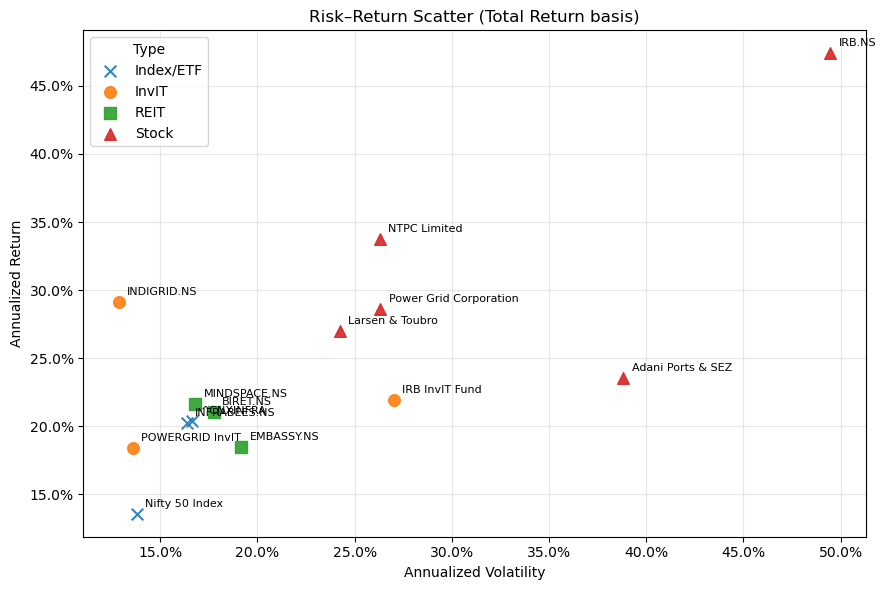

In [21]:
# Pick which dataset to visualize: price-only 'returns' or total-return 'tr_returns'
BASE_RETURNS = tr_returns if 'tr_returns' in globals() else returns

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Build fresh annualized metrics from the chosen dataset
ann_ret = BASE_RETURNS.mean() * 252
ann_vol = BASE_RETURNS.std()  * (252 ** 0.5)

scatter = pd.DataFrame({
    "Annual_Return": ann_ret,
    "Annual_Volatility": ann_vol,
    "Type": [instrument_type.get(t, "Index/ETF") for t in ann_ret.index],
    "Name": [instrument_meta.get(t, {}).get("Name", t) for t in ann_ret.index]
}).dropna()

marker_map = {"InvIT":"o", "REIT":"s", "Stock":"^", "Index":"x", "Index/ETF":"x"}

plt.figure(figsize=(9,6))
for tp, grp in scatter.groupby("Type"):
    plt.scatter(grp["Annual_Volatility"], grp["Annual_Return"],
                label=tp, marker=marker_map.get(tp, "o"), s=70, alpha=0.9)

# annotate points (use short names to avoid clutter)
for t, row in scatter.iterrows():
    label = row["Name"] if len(row["Name"]) <= 22 else t
    plt.annotate(label, (row["Annual_Volatility"], row["Annual_Return"]),
                 textcoords="offset points", xytext=(6,5), fontsize=8)

plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Risk–Return Scatter ({} basis)".format("Total Return" if BASE_RETURNS is tr_returns else "Price Only"))
plt.grid(True, alpha=0.3)
plt.legend(title="Type")
plt.tight_layout()
plt.show()


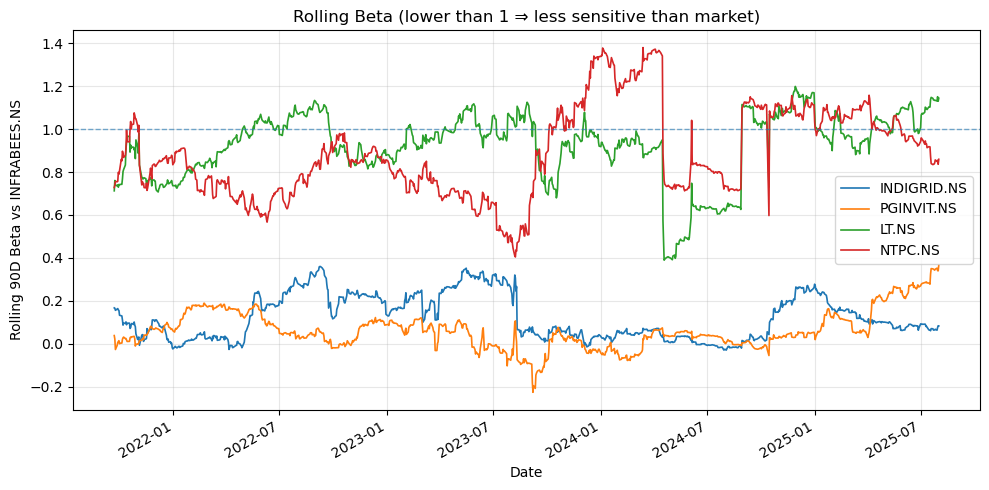

In [22]:
# Rolling beta helper (90-day by default)
def rolling_beta(ret_df: pd.DataFrame, market_col: str, window: int = 90) -> pd.DataFrame:
    var_m = ret_df[market_col].rolling(window).var()
    betas = {}
    for t in ret_df.columns:
        if t == market_col: 
            continue
        cov_im = ret_df[t].rolling(window).cov(ret_df[market_col])
        betas[t] = (cov_im / var_m)
    return pd.DataFrame(betas)

# Use price returns for beta (standard)
rb = rolling_beta(returns, MARKET, window=90)

# Choose what to show (auto-filter to available)
TICKERS_TO_PLOT_BETA = [t for t in ["INDIGRID.NS", "PGINVIT.NS", "LT.NS", "NTPC.NS"] if t in rb.columns]

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
rb[TICKERS_TO_PLOT_BETA].dropna().plot(ax=plt.gca(), linewidth=1.2)
plt.axhline(1.0, linestyle="--", linewidth=1, alpha=0.6)
plt.xlabel("Date")
plt.ylabel("Rolling 90D Beta vs {}".format(MARKET))
plt.title("Rolling Beta (lower than 1 ⇒ less sensitive than market)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_19220\2008210258.py:50: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(grp["Annual_Volatility"], grp["Annual_Return"],


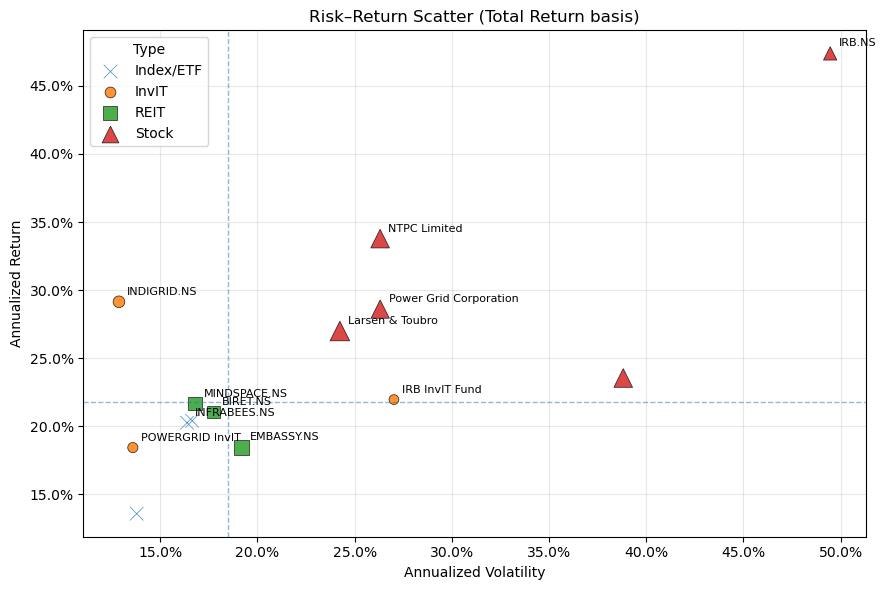

Median annual return = 21.82%, median vol = 18.47%.
Labeling all InvITs/REITs, market proxy, and notable Stocks (top return & lowest vol).


In [23]:
# Pick dataset: total-return if available, else price-only
BASE_RETURNS = tr_returns if 'tr_returns' in globals() else returns

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

# Try to use adjustText for nicer label placement (optional)
try:
    from adjustText import adjust_text
    _ADJUST = True
except Exception:
    _ADJUST = False

# Build metrics
ann_ret = BASE_RETURNS.mean() * 252
ann_vol = BASE_RETURNS.std()  * (252 ** 0.5)

scatter = pd.DataFrame({
    "Annual_Return": ann_ret,
    "Annual_Volatility": ann_vol,
    "Type": [instrument_type.get(t, "Index/ETF") for t in ann_ret.index],
    "Name": [instrument_meta.get(t, {}).get("Name", t) for t in ann_ret.index]
})

# Add market-cap to scale marker size (fallback to median if missing)
if "Market_Cap_INR" in summary.columns:
    scatter = scatter.join(summary["Market_Cap_INR"], how="left")
else:
    scatter["Market_Cap_INR"] = np.nan

mc = scatter["Market_Cap_INR"].copy()
if mc.isna().all():
    mc = pd.Series(np.repeat(1e9, len(scatter)), index=scatter.index)  # dummy
else:
    mc = mc.fillna(mc[mc>0].median())

# Size ~ log(market cap)
mc_log = np.log10(mc + 1)
sizes = 50 + 150 * (mc_log - mc_log.min()) / (mc_log.max() - mc_log.min() + 1e-9)
scatter["size"] = sizes

# Marker shapes by Type
marker_map = {"InvIT":"o", "REIT":"s", "Stock":"^", "Index":"x", "Index/ETF":"x"}

fig, ax = plt.subplots(figsize=(9,6))

# Plot grouped by Type (no manual colors; let matplotlib handle palette)
for tp, grp in scatter.groupby("Type"):
    ax.scatter(grp["Annual_Volatility"], grp["Annual_Return"],
               label=tp, marker=marker_map.get(tp, "o"),
               s=grp["size"], alpha=0.85, linewidths=0.5, edgecolors="k")

# Median lines to create easy quadrants
x_med = scatter["Annual_Volatility"].median()
y_med = scatter["Annual_Return"].median()
ax.axvline(x_med, linestyle="--", linewidth=1, alpha=0.5)
ax.axhline(y_med, linestyle="--", linewidth=1, alpha=0.5)

# Decide which points to label:
# - All InvITs + REITs
# - The market proxy used
# - Stocks: top 3 by return and top 3 with lowest volatility
to_label_idx = set(scatter.index[scatter["Type"].isin(["InvIT","REIT"])].tolist())
if 'MARKET' in globals() and MARKET in scatter.index:
    to_label_idx.add(MARKET)
stock_df = scatter[scatter["Type"]=="Stock"]
if not stock_df.empty:
    top_return = stock_df.sort_values("Annual_Return", ascending=False).head(3).index.tolist()
    low_vol    = stock_df.sort_values("Annual_Volatility", ascending=True).head(3).index.tolist()
    to_label_idx.update(top_return + low_vol)

texts = []
for idx, row in scatter.loc[list(to_label_idx)].iterrows():
    label = row["Name"] if len(str(row["Name"])) <= 24 else str(idx)
    txt = ax.annotate(label, (row["Annual_Volatility"], row["Annual_Return"]),
                      textcoords="offset points", xytext=(6,5), fontsize=8)
    texts.append(txt)

# If adjustText is available, de-overlap labels
if _ADJUST:
    adjust_text(texts, ax=ax, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle='-', lw=0.5))

ax.xaxis.set_major_formatter(PercentFormatter(1.0))
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xlabel("Annualized Volatility")
ax.set_ylabel("Annualized Return")
ax.set_title("Risk–Return Scatter ({} basis)".format("Total Return" if BASE_RETURNS is tr_returns else "Price Only"))
ax.grid(True, alpha=0.3)
ax.legend(title="Type", frameon=True)
plt.tight_layout()
plt.show()

# Quick takeaway printed for your notes
print(f"Median annual return = {y_med:.2%}, median vol = {x_med:.2%}.")
print("Labeling all InvITs/REITs, market proxy, and notable Stocks (top return & lowest vol).")


In [24]:
# Use total-return returns if available; else fall back to price returns
BASE_RETURNS = tr_returns if 'tr_returns' in globals() else returns
RF_SER = rf_daily_tr_returns if ('tr_returns' in globals() and 'rf_daily_tr_returns' in globals()) else rf_daily_returns

# Annualized metrics per ticker
ann_ret = BASE_RETURNS.mean() * 252
ann_vol = BASE_RETURNS.std()  * (252**0.5)
sharpe  = (ann_ret - (RF_SER.mean()*252)) / ann_vol

by_ticker = pd.DataFrame({
    "Type": [instrument_type.get(t, "Other") for t in BASE_RETURNS.columns],
    "Annual_Return": ann_ret,
    "Annual_Volatility": ann_vol,
    "Sharpe": sharpe
}).dropna()

# keep only the 3 groups
by_ticker = by_ticker[by_ticker["Type"].isin(["InvIT","REIT","Stock"])]

# ---- CAPM (Total Return, time-varying RF) on MARKET; auto-compute if needed
if 'robust_TR_timeRF' in globals() and MARKET in robust_TR_timeRF:
    capm_TR = robust_TR_timeRF[MARKET]
else:
    # quick compute on the fly
    def capm_hac(excess_asset, excess_mkt, hac_lags=5):
        X = sm.add_constant(excess_mkt.values)
        y = excess_asset.values
        m = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": hac_lags})
        return m.params[0]*252, m.params[1], m.rsquared
    rows = []
    for c in BASE_RETURNS.columns:
        if c == MARKET: 
            continue
        df = BASE_RETURNS[[c, MARKET]].dropna()
        if df.empty: 
            continue
        ex_i = df[c] - RF_SER.reindex(df.index)
        ex_m = df[MARKET] - RF_SER.reindex(df.index)
        a, b, r2 = capm_hac(ex_i, ex_m)
        rows.append({"Ticker": c, "Alpha_annual": a, "Beta": b, "R2": r2})
    capm_TR = pd.DataFrame(rows).set_index("Ticker")

capm_TR["Type"] = [instrument_type.get(t, "Other") for t in capm_TR.index]
capm_TR = capm_TR[capm_TR["Type"].isin(["InvIT","REIT","Stock"])]

# ---- Group roll-ups
type_metrics = by_ticker.groupby("Type").agg(
    n=("Annual_Return","count"),
    Annual_Return_mean=("Annual_Return","mean"),
    Annual_Return_median=("Annual_Return","median"),
    Annual_Volatility_mean=("Annual_Volatility","mean"),
    Sharpe_mean=("Sharpe","mean")
)

type_capm = capm_TR.groupby("Type").agg(
    Alpha_mean=("Alpha_annual","mean"),
    Beta_mean=("Beta","mean"),
    R2_mean=("R2","mean")
)

type_summary = type_metrics.join(type_capm, how="left")

# pretty display in %
ts = type_summary.copy()
for c in ["Annual_Return_mean","Annual_Return_median","Annual_Volatility_mean","Alpha_mean"]:
    ts[c] = (ts[c]*100).round(2)
ts["Sharpe_mean"] = ts["Sharpe_mean"].round(2)
ts["Beta_mean"]   = ts["Beta_mean"].round(2)
ts["R2_mean"]     = ts["R2_mean"].round(2)
ts.rename(columns={
    "n":"Count",
    "Annual_Return_mean":"Ann. Return (avg) %",
    "Annual_Return_median":"Ann. Return (median) %",
    "Annual_Volatility_mean":"Ann. Vol (avg) %",
    "Sharpe_mean":"Sharpe (avg)",
    "Alpha_mean":"Alpha (avg) %",
    "Beta_mean":"Beta (avg)",
    "R2_mean":"R² (avg)"
}, inplace=True)
ts


,Count,Ann. Return (avg) %,Ann. Return (median) %,Ann. Vol (avg) %,Sharpe (avg),Alpha (avg) %,Beta (avg),R² (avg)
Type,,,,,,,,
InvIT,3,23.1800,21.9600,17.8300,1.0400,14.4900,0.1300,0.0100
REIT,3,20.3900,21.0600,17.9100,0.7500,12.0300,0.1000,0.0100
Stock,5,32.0600,28.6100,33.0300,0.7800,11.8700,0.9900,0.2600


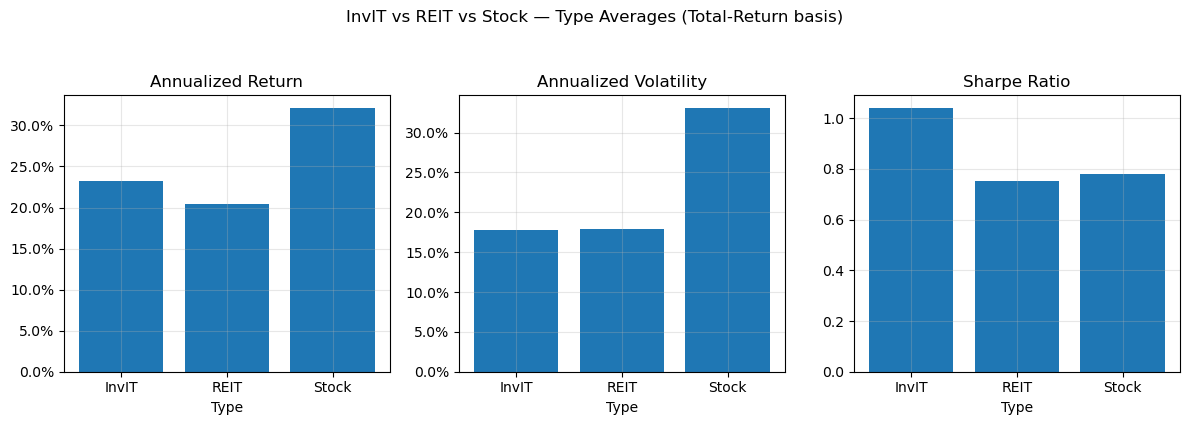

In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

plot_df = type_summary.copy()

fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=False)
cols = [("Annual_Return_mean","Annualized Return"),
        ("Annual_Volatility_mean","Annualized Volatility"),
        ("Sharpe_mean","Sharpe Ratio")]

for ax_i, (col, title) in zip(axes, cols):
    y = plot_df[col]
    ax_i.bar(y.index, y.values)
    if "Return" in title or "Volatility" in title:
        ax_i.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax_i.set_title(title)
    ax_i.set_xlabel("Type")
    ax_i.grid(True, alpha=0.3)

plt.suptitle("InvIT vs REIT vs Stock — Type Averages (Total-Return basis)", y=1.05)
plt.tight_layout()
plt.show()


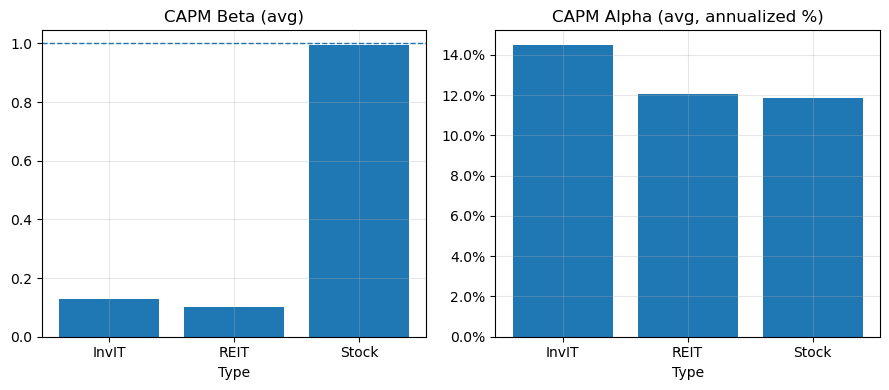

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))
# Beta
axes[0].bar(type_summary.index, type_summary["Beta_mean"])
axes[0].axhline(1.0, linestyle="--", linewidth=1)
axes[0].set_title("CAPM Beta (avg)")
axes[0].set_xlabel("Type")
axes[0].grid(True, alpha=0.3)

# Alpha (in %)
axes[1].bar(type_summary.index, type_summary["Alpha_mean"]*100)
axes[1].yaxis.set_major_formatter(PercentFormatter(100))
axes[1].set_title("CAPM Alpha (avg, annualized %)")
axes[1].set_xlabel("Type")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


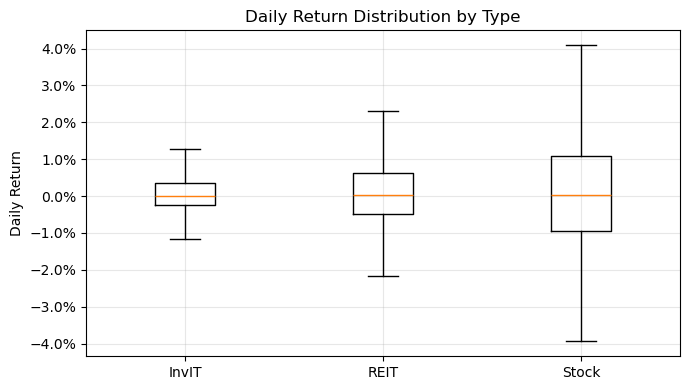

In [27]:
# stack returns by Type
stack = []
for c in BASE_RETURNS.columns:
    tp = instrument_type.get(c, "Other")
    if tp in ["InvIT","REIT","Stock"]:
        df = pd.DataFrame({"Type": tp, "Ret": BASE_RETURNS[c].dropna()})
        stack.append(df)
stack = pd.concat(stack, axis=0)

fig, ax = plt.subplots(figsize=(7,4))
data = [stack.loc[stack["Type"]==t, "Ret"] for t in ["InvIT","REIT","Stock"]]
ax.boxplot(data, labels=["InvIT","REIT","Stock"], showfliers=False)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_title("Daily Return Distribution by Type")
ax.set_ylabel("Daily Return")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Latest rolling betas (window=90 days):
REIT    0.0274
InvIT   0.2604
Stock   1.0621
Name: 2025-07-31 00:00:00, dtype: float64


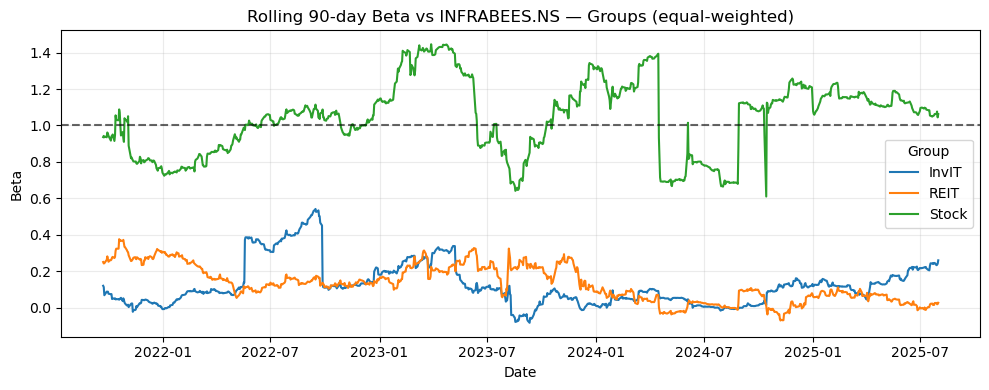

In [ ]:
# Rolling beta by Type vs market (index) — equal-weighted group returns
# Uses existing rolling_beta(...) and variables in the notebook.

# Choose returns panel (prefer total-return if available)
BASE_RETURNS = tr_returns if 'tr_returns' in globals() else returns

# Parameters
WINDOW = 90  # rolling window in days
GROUP_TYPES = ["InvIT", "REIT", "Stock"] 

# Build equal-weighted group return series
group_returns = {}
for tp in GROUP_TYPES:
    cols = [t for t in BASE_RETURNS.columns if instrument_type.get(t) == tp]
    if not cols:
        continue
    # mean across tickers (skip NaNs)
    group_returns[tp] = BASE_RETURNS[cols].mean(axis=1)

# Ensure market series is present
if 'MARKET' not in globals() or MARKET not in BASE_RETURNS.columns:
    raise ValueError("MARKET proxy not available in RETURNS. Check MARKET variable and returns dataframe.")

# Construct a dataframe with market + groups
grp_df = pd.DataFrame(group_returns)
grp_df[MARKET] = BASE_RETURNS[MARKET]

# Align index and drop rows where market is NA (rolling_beta expects market series present)
grp_df = grp_df.dropna(subset=[MARKET])

# Compute rolling betas (will return a DataFrame with columns = group names)
roll_beta_groups = rolling_beta(grp_df, MARKET, window=WINDOW)

# Simple display: latest available rolling betas
latest_betas = roll_beta_groups.dropna().iloc[-1].sort_values()
print("Latest rolling betas (window={} days):".format(WINDOW))
print(latest_betas)

# Plot rolling betas
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
for col in roll_beta_groups.columns:
    plt.plot(roll_beta_groups.index, roll_beta_groups[col], label=col, linewidth=1.5)
plt.axhline(1.0, linestyle="--", color="k", alpha=0.6)
plt.legend(title="Group")
plt.title(f"Rolling {WINDOW}-day Beta vs {MARKET} — Groups (equal-weighted)")
plt.ylabel("Beta")
plt.xlabel("Date")
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()